In [ ]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
# Load and filter data
MIN_REVENUE_KSEK = 1_000
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[(df["ser_aktiv"] == 1) & (df["sme_category"].isin(["Small", "Medium"]))]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 117 | Samples: 889,889
Target distribution:
target_next_year
0    875385
1     14504
Name: count, dtype: Int64
Imbalance: 60.4:1


In [78]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train: {len(X_train):,} | Val: {len(X_val):,}")

Train: 711,911 | Val: 177,978


In [26]:
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

In [28]:
from scipy.special import expit

class LightGBMWrapper:
    """Wrapper to make native API behave like sklearn API."""
    
    def __init__(self, booster, init_score=None, use_sigmoid=True):
        """
        Parameters
        ----------
        booster : lgb.Booster
            Trained LightGBM booster
        init_score : float or None
            Init score from training (needed for custom objectives)
        use_sigmoid : bool
            Whether to apply sigmoid (True for custom objectives)
        """
        self.booster = booster
        self.init_score = init_score
        self.use_sigmoid = use_sigmoid
    
    def predict_proba(self, X):
        """Mimic sklearn's predict_proba."""
        raw_preds = self.booster.predict(X)
        
        if self.use_sigmoid and self.init_score is not None:
            proba_class1 = expit(self.init_score + raw_preds)
        else:
            proba_class1 = raw_preds
        
        proba_class0 = 1 - proba_class1
        return np.vstack([proba_class0, proba_class1]).T
    
    def predict(self, X, threshold=0.5):
        """Mimic sklearn's predict."""
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)
    
    @property
    def feature_importances_(self):
        """Mimic sklearn's feature_importances_."""
        return self.booster.feature_importance(importance_type='gain')

In [45]:
# Initialize focal loss
class_imbalance = (y_train == 0).sum() / (y_train == 1).sum()

focal_loss = FocalLoss(gamma=2, alpha=0.9)  # Adjust gamma and alpha as needed
init_score = focal_loss.init_score(y_train)

# Prepare datasets with init_score
train_data = lgb.Dataset(
    X_train, y_train,
    init_score=np.full_like(y_train, init_score, dtype=float)
)
val_data = lgb.Dataset(
    X_val, y_val,
    init_score=np.full_like(y_val, init_score, dtype=float),
    reference=train_data
)

# Convert parameters to native API format
params = {
    'learning_rate': 0.05,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'subsample_freq': 1,  # Needed for subsample to work
    'random_state': 42,
    'verbose': -1,
    'objective': focal_loss.lgb_obj,  # Custom objective

    # 'reg_alpha': 0.1,
    # 'reg_lambda': 0.1,
    # Note: is_unbalance removed (doesn't work with custom objectives)
    # Note: objective removed (using custom objective via fobj)
    # Note: metric removed (using custom eval via feval)
}

# Train LightGBM with focal loss
start_time = time.time()
booster = lgb.train(
    params,
    train_data,
    num_boost_round=10000,  # Replaces n_estimators
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    feval=focal_loss.lgb_eval,  # Custom evaluation metric
    callbacks=[
        lgb.early_stopping(50, verbose=True),
        lgb.log_evaluation(50)
    ]
)
training_time = time.time() - start_time
print(f"\nLightGBM training completed in {training_time:.1f}s ({training_time/60:.1f} min)")
print(f"\nBest iteration: {booster.best_iteration}")

# Wrap the booster to get sklearn-like interface
model = LightGBMWrapper(booster, init_score=init_score, use_sigmoid=True)

# Now model.predict_proba() and model.predict() work as before!

Training until validation scores don't improve for 50 rounds
[50]	train's focal_loss: 0.00443546	val's focal_loss: 0.00442676
[100]	train's focal_loss: 0.00398444	val's focal_loss: 0.00401587
[150]	train's focal_loss: 0.00379506	val's focal_loss: 0.00386804
[200]	train's focal_loss: 0.00366902	val's focal_loss: 0.00378542
[250]	train's focal_loss: 0.00357148	val's focal_loss: 0.00373125
[300]	train's focal_loss: 0.00349379	val's focal_loss: 0.00369895
[350]	train's focal_loss: 0.00343125	val's focal_loss: 0.00367729
[400]	train's focal_loss: 0.00337148	val's focal_loss: 0.00366273
[450]	train's focal_loss: 0.0033246	val's focal_loss: 0.00365811
[500]	train's focal_loss: 0.00327582	val's focal_loss: 0.00365143
[550]	train's focal_loss: 0.00322841	val's focal_loss: 0.00364632
[600]	train's focal_loss: 0.00318586	val's focal_loss: 0.00364097
[650]	train's focal_loss: 0.00314137	val's focal_loss: 0.00363862
[700]	train's focal_loss: 0.00309631	val's focal_loss: 0.00363334
[750]	train's foc

In [107]:
model = lgb.LGBMClassifier(
        n_estimators=10_000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary',
        is_unbalance=False,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        metric='logloss',
        # reg_alpha=0.1,
        # reg_lambda=0.1
)

start_time = time.time()

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(50, verbose=True), lgb.log_evaluation(50)]
)

training_time = time.time() - start_time
print(f"\nLightGBM training completed in {training_time:.1f}s ({training_time/60:.1f} min)")

print(f"\nBest iteration: {model.best_iteration_}")

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.035281	valid_1's binary_logloss: 0.0371045
[100]	training's binary_logloss: 0.0313607	valid_1's binary_logloss: 0.0352008
[150]	training's binary_logloss: 0.0286946	valid_1's binary_logloss: 0.034633
[200]	training's binary_logloss: 0.0266967	valid_1's binary_logloss: 0.0344195
[250]	training's binary_logloss: 0.0251157	valid_1's binary_logloss: 0.0343959
[300]	training's binary_logloss: 0.0237355	valid_1's binary_logloss: 0.0343368
[350]	training's binary_logloss: 0.0226336	valid_1's binary_logloss: 0.0342838
[400]	training's binary_logloss: 0.0215127	valid_1's binary_logloss: 0.0342226
[450]	training's binary_logloss: 0.0205448	valid_1's binary_logloss: 0.0341653
[500]	training's binary_logloss: 0.019633	valid_1's binary_logloss: 0.034118
[550]	training's binary_logloss: 0.0187851	valid_1's binary_logloss: 0.0340686
[600]	training's binary_logloss: 0.017998	valid_1's binary_logloss: 0.03404

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred_proba, n_bins=100, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

In [ ]:
# Evaluate
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"AUC: {auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

plot_calibration_curve(y_val, y_pred_proba, model_name="Predicted Model")

AUC: 0.9625
PR-AUC: 0.6869

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    175077
         1.0       0.93      0.53      0.67      2901

    accuracy                           0.99    177978
   macro avg       0.96      0.76      0.83    177978
weighted avg       0.99      0.99      0.99    177978


Confusion Matrix:
[[174962    115]
 [  1370   1531]]


Top 117 Features (by Gain):
                        feature   importance
  years_since_last_credit_event 4.453533e+06
                    ny_avkegkap 4.368811e+06
                        ny_omsf 1.402433e+06
           br09_tillgsu_yoy_pct 1.328098e+06
                       ny_solid 1.081566e+06
          rr07_rorresul_yoy_pct 5.944152e+05
     ratio_share_capital_equity 3.137477e+05
                  rr07_rorresul 2.820768e+05
           ratio_cash_liquidity 2.315595e+05
          ratio_dividend_payout 2.243467e+05
      ratio_secured_debt_assets 2.111006e+05
                       dpo_days 2.095165e+05
                ny_foradlvpanst 1.775360e+05
ratio_ebit_interest_cov_yoy_pct 1.653073e+05
                   br09_tillgsu 1.616851e+05
              ny_solid_yoy_diff 1.570931e+05
           ny_skuldgrd_yoy_diff 1.265159e+05
                          ny_rs 1.235550e+05
              dpo_days_yoy_diff 1.220520e+05
              dso_days_yoy_diff 1.198652e+05
                    company

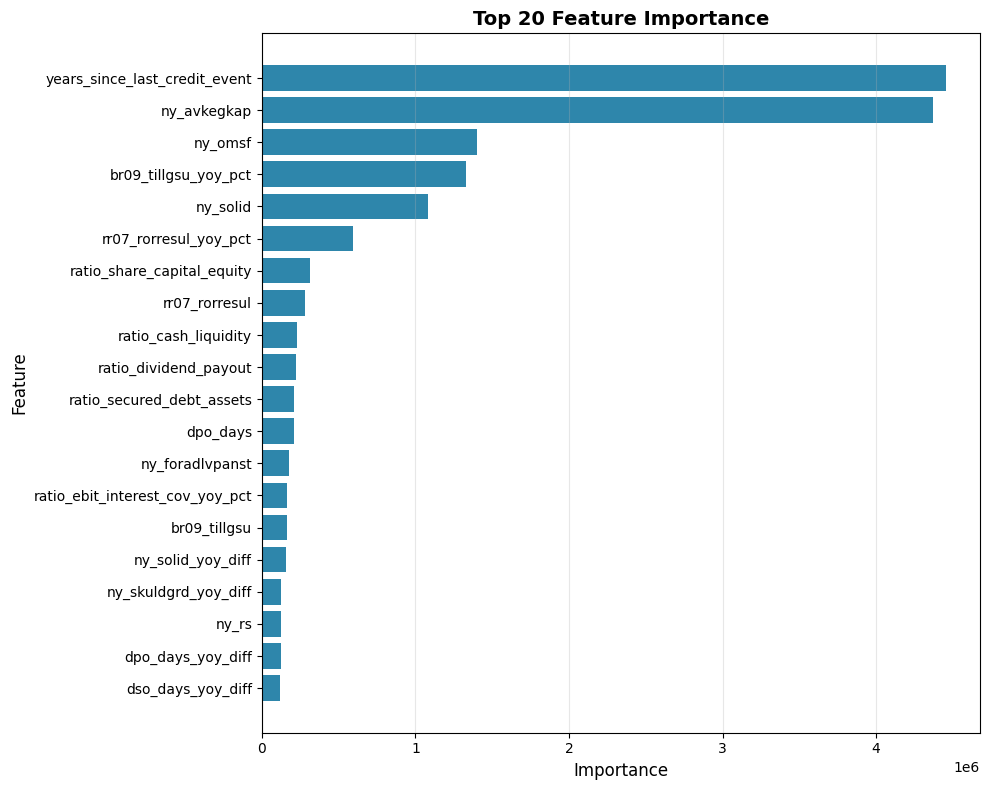


Feature Group Importance Analysis
               group  total_importance  mean_importance  feature_count
               OTHER      8.847639e+06    276488.719855             32
              CRISIS      4.641529e+06    580191.091649              8
               TREND      4.325967e+06    102999.224005             42
               RATIO      1.464869e+06     91554.300505             16
               MACRO      3.317453e+05     20734.079209             16
LIQUIDITY_EFFICIENCY      3.093122e+05    103104.066610              3


In [84]:
# Feature importance analysis
from credit_risk_xai.modeling import get_feature_importance, plot_feature_importance, analyze_feature_groups
from credit_risk_xai.config import (
    RATIO_FEATURE_NAMES, 
    LIQUIDITY_EFFICIENCY_FEATURES, 
    TREND_FEATURE_NAMES, 
    CRISIS_FEATURE_NAMES, 
    MACRO_FEATURE_NAMES
)

# 1. Get LightGBM feature importance (using gain)
importance_df = get_feature_importance(model, X_train, importance_type='gain', top_n=117)
print("Top 117 Features (by Gain):")
print(importance_df.to_string(index=False))

# 2. Visualize feature importance
plot_feature_importance(importance_df, top_n=20, show=True)

# 3. Analyze by feature groups
feature_groups = {
    "RATIO": RATIO_FEATURE_NAMES,
    "LIQUIDITY_EFFICIENCY": LIQUIDITY_EFFICIENCY_FEATURES,
    "TREND": TREND_FEATURE_NAMES,
    "CRISIS": CRISIS_FEATURE_NAMES,
    "MACRO": MACRO_FEATURE_NAMES,
}

group_stats = analyze_feature_groups(model, X_train, feature_groups, importance_type='gain')
print("\n" + "="*80)
print("Feature Group Importance Analysis")
print("="*80)
print(group_stats.to_string(index=False))

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top 117 Features (by SHAP):
                        feature  mean_abs_shap
          ratio_dividend_payout       0.402976
                    ny_avkegkap       0.280519
                       dpo_days       0.186866
                    company_age       0.184736
                       ny_solid       0.179285
                     ny_kapomsh       0.170773
                          ny_rs       0.161508
           ratio_cash_liquidity       0.158656
    ratio_cash_liquidity_avg_2y       0.156852
            bransch_sni071_konv       0.128683
                ny_foradlvpanst       0.127064
                    knc_kncfall       0.125061
                   br07b_kabasu       0.124731
             rr01_ntoms_yoy_abs       0.122961
      ratio_secured_debt_assets       0.111431
ratio_ebit_interest_cov_yoy_pct       0.106118
                  rr07_rorresul       0.103308
 ratio_retained_earnings_equity       0.100190
              dpo_days_yoy_diff       0.100189
                   ny_nettomarg 

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


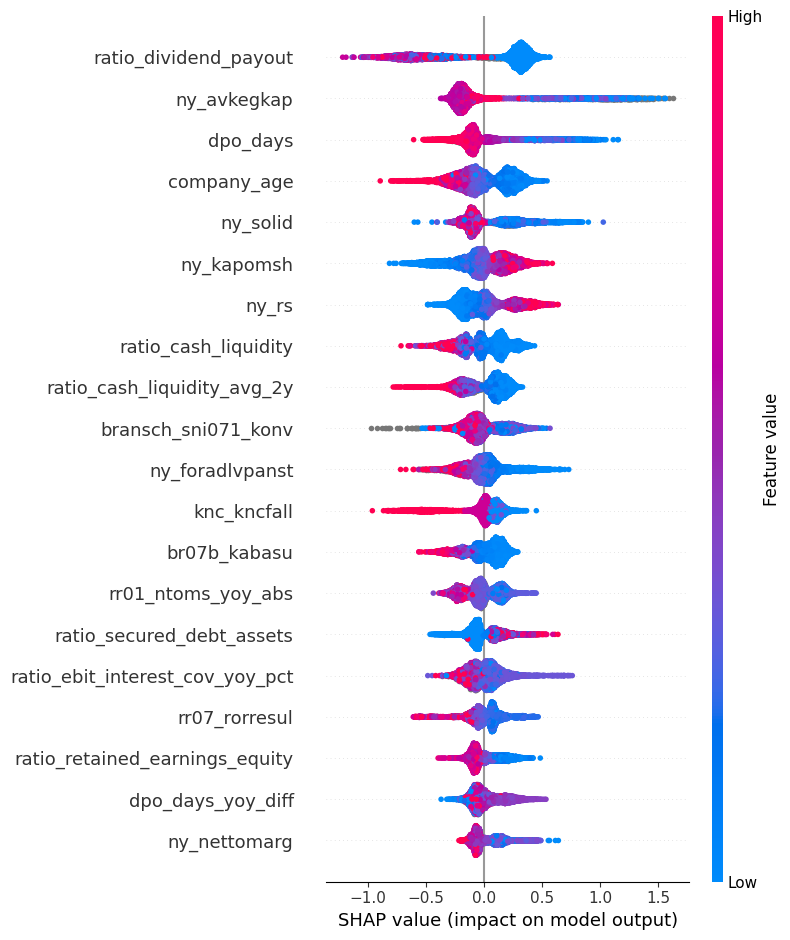

In [85]:
# SHAP analysis
from credit_risk_xai.modeling import get_shap_feature_importance, compute_shap_values
import shap

# 1. Compute SHAP-based feature importance
sample_size = min(10_000, len(X_val))
shap_importance = get_shap_feature_importance(model, X_val, max_samples=sample_size, top_n=117)

print("Top 117 Features (by SHAP):")
print(shap_importance.to_string(index=False))

# 2. Compare native importance vs SHAP
comparison = importance_df.merge(shap_importance, on='feature', how='inner')
comparison['importance_rank'] = comparison['importance'].rank(ascending=False)
comparison['shap_rank'] = comparison['mean_abs_shap'].rank(ascending=False)
comparison['rank_diff'] = abs(comparison['importance_rank'] - comparison['shap_rank'])
comparison = comparison.sort_values('rank_diff', ascending=False)

print("\n" + "="*80)
print("Features with Largest Rank Difference (Gain vs SHAP)")
print("="*80)
print(comparison[['feature', 'importance', 'importance_rank', 'mean_abs_shap', 'shap_rank', 'rank_diff']].head(15).to_string(index=False))

# 3. Generate SHAP summary plot
print(f"\nGenerating SHAP summary plot on {sample_size:,} samples...")
explainer, shap_values, X_sample = compute_shap_values(model, X_val, max_samples=sample_size)

# Handle binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_sample, max_display=20)

In [87]:
# Correlation analysis by financial statement source
from credit_risk_xai.modeling import (
    get_feature_correlations_by_source,
    find_high_correlations,
    plot_correlation_heatmap,
    summarize_within_group_correlations
)
from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

# 1. Summary of within-group correlations
print("=" * 90)
print("WITHIN-GROUP CORRELATION SUMMARY")
print("=" * 90)
group_summary = summarize_within_group_correlations(X_train, FEATURE_GROUPS_BY_SOURCE)
print(group_summary.to_string(index=False))

# 2. Compute correlations for each group
corr_by_source = get_feature_correlations_by_source(X_train, FEATURE_GROUPS_BY_SOURCE)

# 3. Find and display high correlations in each group
print("\n" + "=" * 90)
print("HIGH CORRELATIONS BY GROUP (|r| > 0.7)")
print("=" * 90)

for group_name in ["MACRO", "DERIVED_RATIOS", "WORKING_CAPITAL", "OPERATIONAL"]:
    if group_name not in corr_by_source:
        continue
    
    high_corrs = find_high_correlations(corr_by_source[group_name], threshold=0.7, top_n=50)
    
    if len(high_corrs) > 0:
        print(f"\n{group_name} - Top 50 Correlated Pairs:")
        print(high_corrs.to_string(index=False))
    else:
        print(f"\n{group_name} - No correlations above 0.7")

WITHIN-GROUP CORRELATION SUMMARY
           group  feature_count  mean_corr  median_corr  max_corr  min_corr  high_corr_pairs
  CRISIS_HISTORY              8   0.546190     0.822648  0.999686 -0.911094               20
INCOME_STATEMENT              9   0.165416     0.009577  0.991029 -0.000013                6
   BALANCE_SHEET              9   0.140891     0.009853  0.904377 -0.056832                3
  DERIVED_RATIOS             19   0.032837    -0.000003  0.968653 -0.943930               14
 WORKING_CAPITAL             10   0.032353    -0.000006  0.476138 -0.943930                1
          TRENDS             42   0.022871     0.000119  0.957414 -0.982638               24
           MACRO             16   0.022019     0.000171  0.999994 -0.691560                5
     OPERATIONAL              5   0.011367     0.000356  0.137555 -0.056125                0

HIGH CORRELATIONS BY GROUP (|r| > 0.7)

MACRO - Top 50 Correlated Pairs:
          feature_1             feature_2  correlation  

Generating correlation heatmap for MACRO features...


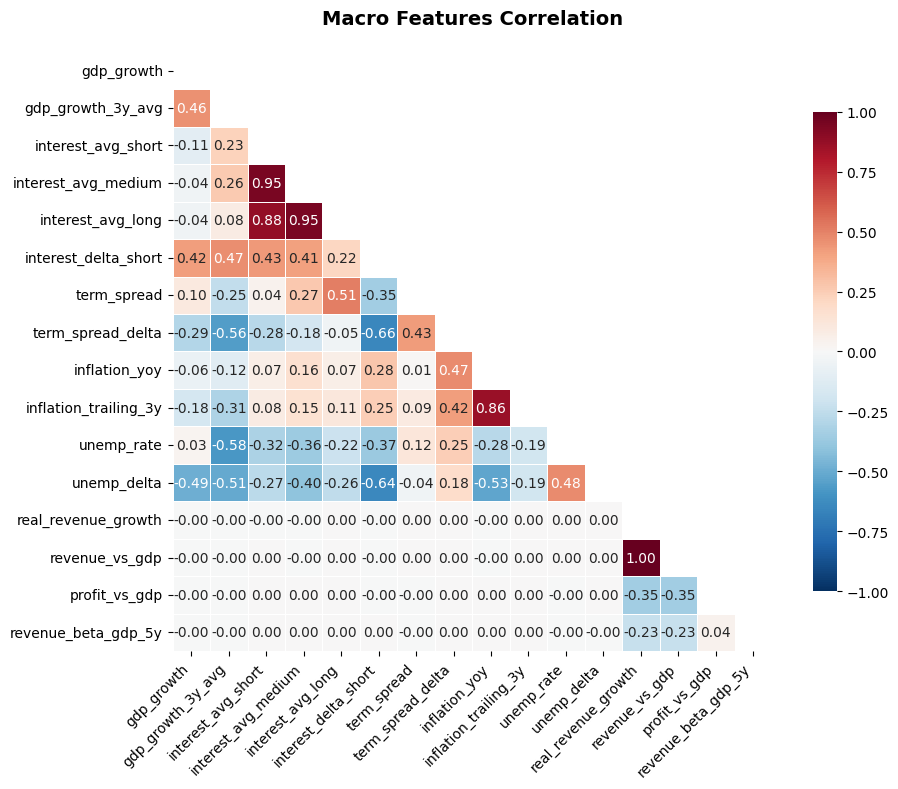


Generating correlation heatmap for WORKING_CAPITAL features...


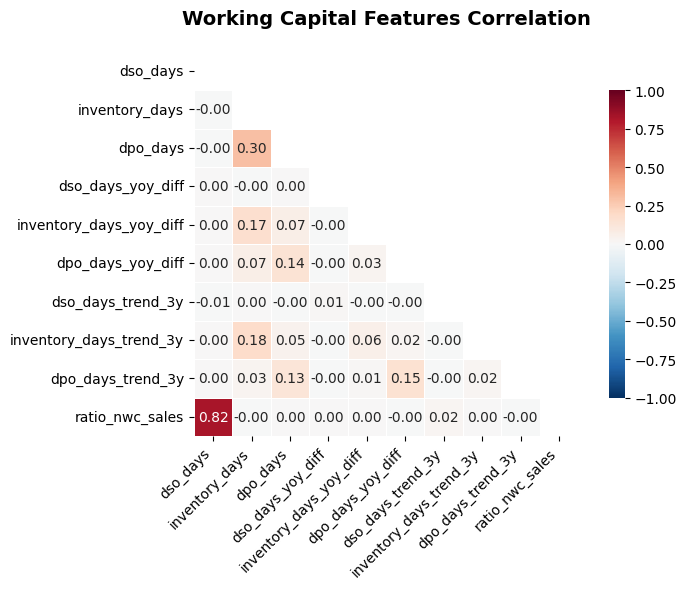


Generating correlation heatmap for DERIVED_RATIOS features...


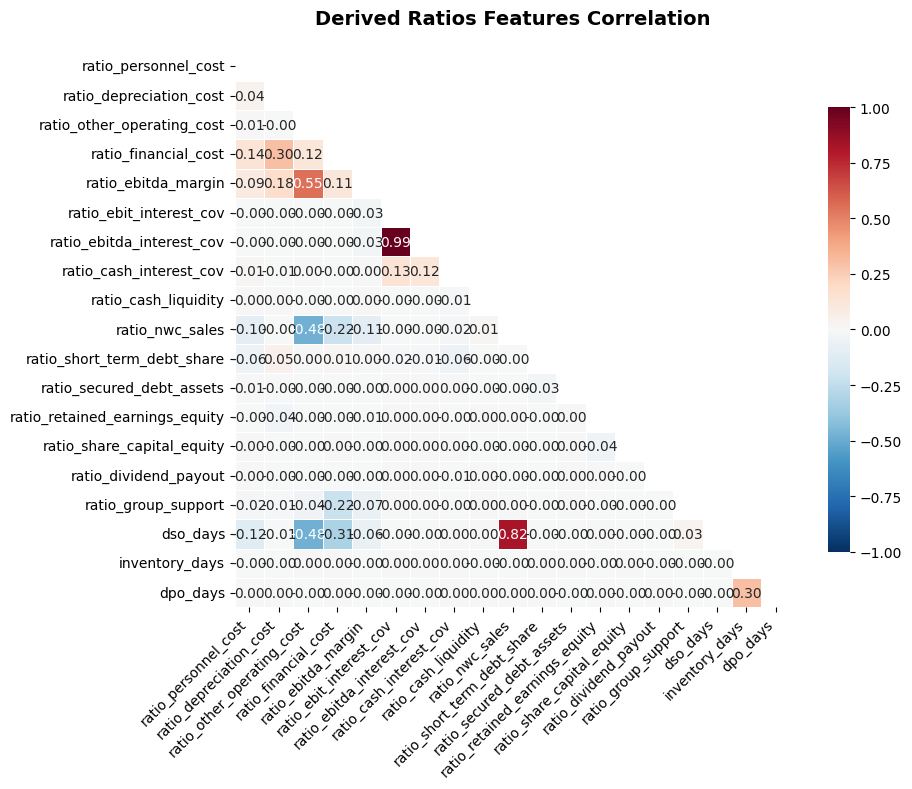


Generating correlation heatmap for OPERATIONAL features...


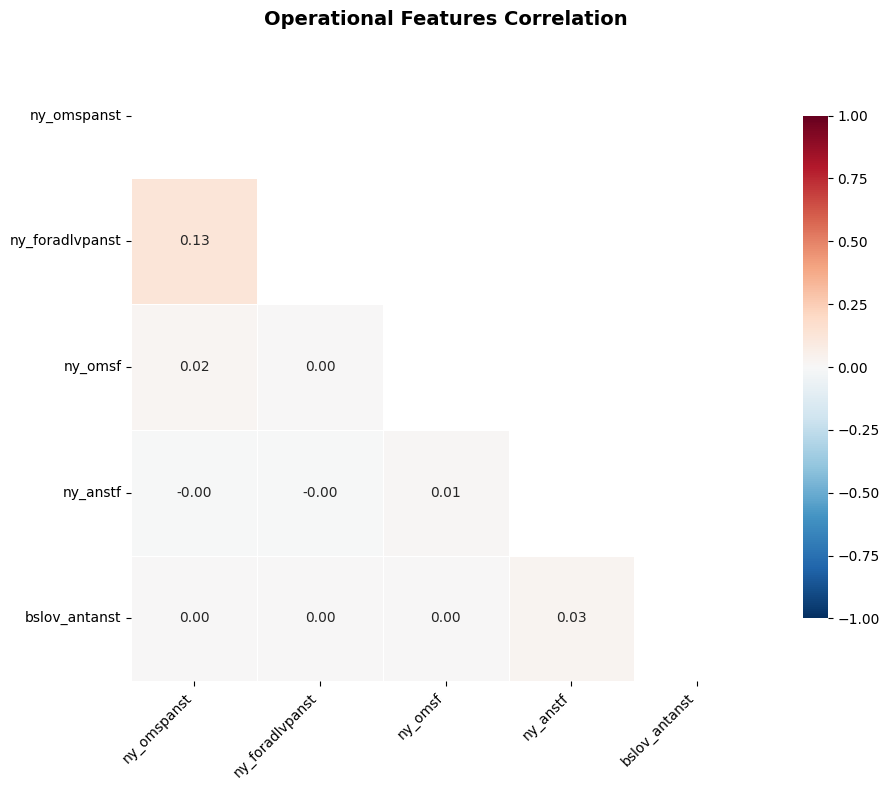

In [9]:
# Visualize correlations for selected groups

if "MACRO" in corr_by_source:
    print("Generating correlation heatmap for MACRO features...")
    plot_correlation_heatmap(
        corr_by_source["MACRO"],
        title="Macro Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )

if "WORKING_CAPITAL" in corr_by_source:
    print("\nGenerating correlation heatmap for WORKING_CAPITAL features...")
    plot_correlation_heatmap(
        corr_by_source["WORKING_CAPITAL"],
        title="Working Capital Features Correlation",
        figsize=(8, 6),
        annot=True,
        mask_diagonal=True,
        show=True
    )

if "DERIVED_RATIOS" in corr_by_source:
    print("\nGenerating correlation heatmap for DERIVED_RATIOS features...")
    plot_correlation_heatmap(
        corr_by_source["DERIVED_RATIOS"],
        title="Derived Ratios Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )
if "OPERATIONAL" in corr_by_source:
    print("\nGenerating correlation heatmap for OPERATIONAL features...")
    plot_correlation_heatmap(
        corr_by_source["OPERATIONAL"],
        title="Operational Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )

In [10]:
# Feature-target correlation and comparison with importance
from credit_risk_xai.modeling import analyze_correlation_with_target, compare_correlation_vs_importance

# 1. Features most correlated with default risk
print("=" * 90)
print("TOP 30 FEATURES CORRELATED WITH TARGET (Default Risk)")
print("=" * 90)
target_corr = analyze_correlation_with_target(X_train, y_train, method='pearson', top_n=30)
print(target_corr.to_string(index=False))

# 2. Compare importance vs correlation - identify interesting patterns
print("\n" + "=" * 90)
print("IMPORTANCE vs CORRELATION COMPARISON")
print("=" * 90)
print("High rank_diff = feature has very different importance rank vs correlation rank")
print("=" * 90)

comparison = compare_correlation_vs_importance(X_train, y_train, importance_df, top_n=30)
print(comparison.to_string(index=False))

# 3. Interpret patterns
print("\n" + "=" * 90)
print("INTERPRETATION PATTERNS")
print("=" * 90)

# High importance but low correlation → nonlinear effects
nonlinear_features = comparison[
    (comparison['importance_rank'] <= 20) & 
    (comparison['corr_rank'] > 40)
].head(10)

if len(nonlinear_features) > 0:
    print("\n🔍 High Importance + Low Correlation (Nonlinear/Interaction Effects):")
    print(nonlinear_features[['feature', 'importance_rank', 'corr_rank', 'target_corr']].to_string(index=False))

# High correlation but low importance → redundant features
redundant_features = comparison[
    (comparison['corr_rank'] <= 20) & 
    (comparison['importance_rank'] > 40)
].head(10)

if len(redundant_features) > 0:
    print("\n⚠️  High Correlation + Low Importance (Potentially Redundant):")
    print(redundant_features[['feature', 'importance_rank', 'corr_rank', 'target_corr']].to_string(index=False))

TOP 30 FEATURES CORRELATED WITH TARGET (Default Risk)


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: 

                      feature  correlation  abs_correlation
          event_count_last_5y     0.343475         0.343475
            event_count_total     0.290860         0.290860
         last_event_within_1y     0.284572         0.284572
         last_event_within_2y     0.284490         0.284490
         last_event_within_3y     0.284440         0.284440
         last_event_within_5y     0.284348         0.284348
                  ever_failed     0.283972         0.283972
                     ny_solid    -0.064991         0.064991
years_since_last_credit_event    -0.054549         0.054549
          revenue_drawdown_5y    -0.036711         0.036711
                    ser_stklf     0.025234         0.025234
               equity_cagr_5y    -0.022985         0.022985
     bransch_borsbransch_konv    -0.022919         0.022919
          bransch_sni071_konv    -0.021803         0.021803
                  company_age    -0.019392         0.019392
               equity_cagr_3y    -0.0130

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: 

                       feature   importance  target_corr  importance_rank  corr_rank  rank_diff
                   ever_failed 0.000000e+00     0.283972            116.5        7.0      109.5
          last_event_within_5y 4.039080e+03     0.284348            115.0        6.0      109.0
          last_event_within_3y 1.754260e+04     0.284440            113.0        5.0      108.0
          last_event_within_2y 2.313203e+04     0.284490            112.0        4.0      108.0
                     ser_stklf 1.552865e+04     0.025234            114.0       11.0      103.0
                       ny_omsf 3.917243e+06    -0.000078              6.0      105.0       99.0
          last_event_within_1y 9.697294e+04     0.284572             94.0        3.0       91.0
ratio_retained_earnings_equity 3.089819e+06    -0.000238              8.0       96.0       88.0
           interest_avg_medium 3.926166e+04     0.011087            109.0       22.0       87.0
             interest_avg_long 5.201191e

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
